In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/The Great Hiring Challenge/Experiment-2')

In [4]:
%tensorflow_version 2.x

## Import Packages

In [5]:
import pickle
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Add
from tensorflow.keras.layers import Concatenate, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.metrics import RootMeanSquaredError
from learningratefinder import LearningRateFinder

## Load datasets from saved file

In [6]:
with open('/content/drive/My Drive/Colab Notebooks/The Great Hiring Challenge/TGHC_Dataset_CB.txt', 'rb') as handle: 
    data = handle.read()

processed_dataset = pickle.loads(data)

Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Xpredict = processed_dataset['Xpredict']

print("------------------------- Training Dataset -------------------------")
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain shape: (284780, 512)
Ytrain shape: (284780, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (122049, 512)


In [7]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(Ytrain)
tmp = pt.transform(Ytrain)
Ytrain = pd.DataFrame(tmp, columns=['UnitPrice'])

del processed_dataset
del tmp
gc.collect()

0

## Split training data into train/test datasets

In [ ]:
Xtrain_new, Xtest, Ytrain_new, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.1, random_state=10)

print("------------------------- Training Dataset -------------------------")
print("Xtrain_new shape: {}".format(Xtrain_new.shape))
print("Ytrain_new shape: {}".format(Ytrain_new.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

------------------------- Training Dataset -------------------------
Xtrain shape: (256302, 550)
Ytrain shape: (256302, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (28478, 550)
Ytest shape: (28478, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (122049, 550)


## Build and validate the model

In [11]:
def tghc_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, ))
    x_inp = BatchNormalization()(x_input)
    
    # Fully-connected Layers
    x1 = Dense(units=1024, kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x_inp)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.5)(x1)

    x1 = Dense(units=512, kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x1)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.5)(x1)

    x1 = Dense(units=512, kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x1)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.5)(x1)

    x2 = Dense(units=1024, activation='selu', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x_inp)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.5)(x2)

    x2 = Dense(units=512, activation='selu', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.5)(x2)

    x2 = Dense(units=512, activation='selu', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.5)(x2)

    x3 = Dense(units=1024, activation='swish', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x_inp)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(rate=0.5)(x3)

    x3 = Dense(units=512, activation='swish', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(rate=0.5)(x3)

    x3 = Dense(units=512, activation='swish', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(rate=0.5)(x3)

    x4 = Concatenate()([x1, x2, x3])

    x5 = Dense(units=2048, activation='relu', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x4)
    x5 = BatchNormalization()(x5)
    x5 = Dropout(rate=0.5)(x5)

    x5 = Dense(units=1024, activation='relu', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0001))(x5)
    x5 = BatchNormalization()(x5)
    x5 = Dropout(rate=0.5)(x5)
    
    # Output Layer
    x = Dense(units=1, activation='linear')(x5)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='TGHC_Model')

    return model

In [12]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 1e-1
step_size = 8 * (Xtrain.shape[0] // mini_batch_size)
clr_method = 'triangular2'

# Create and compile the model
model = tghc_model(Xtrain.shape[1])

model.compile(loss='mse', metrics=[RootMeanSquaredError(name='rmse')],
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

model.summary()

Model: "TGHC_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 512)          2048        input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1024)         525312      batch_normalization_10[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 1024)         0           dense_10[0][0]                   
_________________________________________________________________________________________

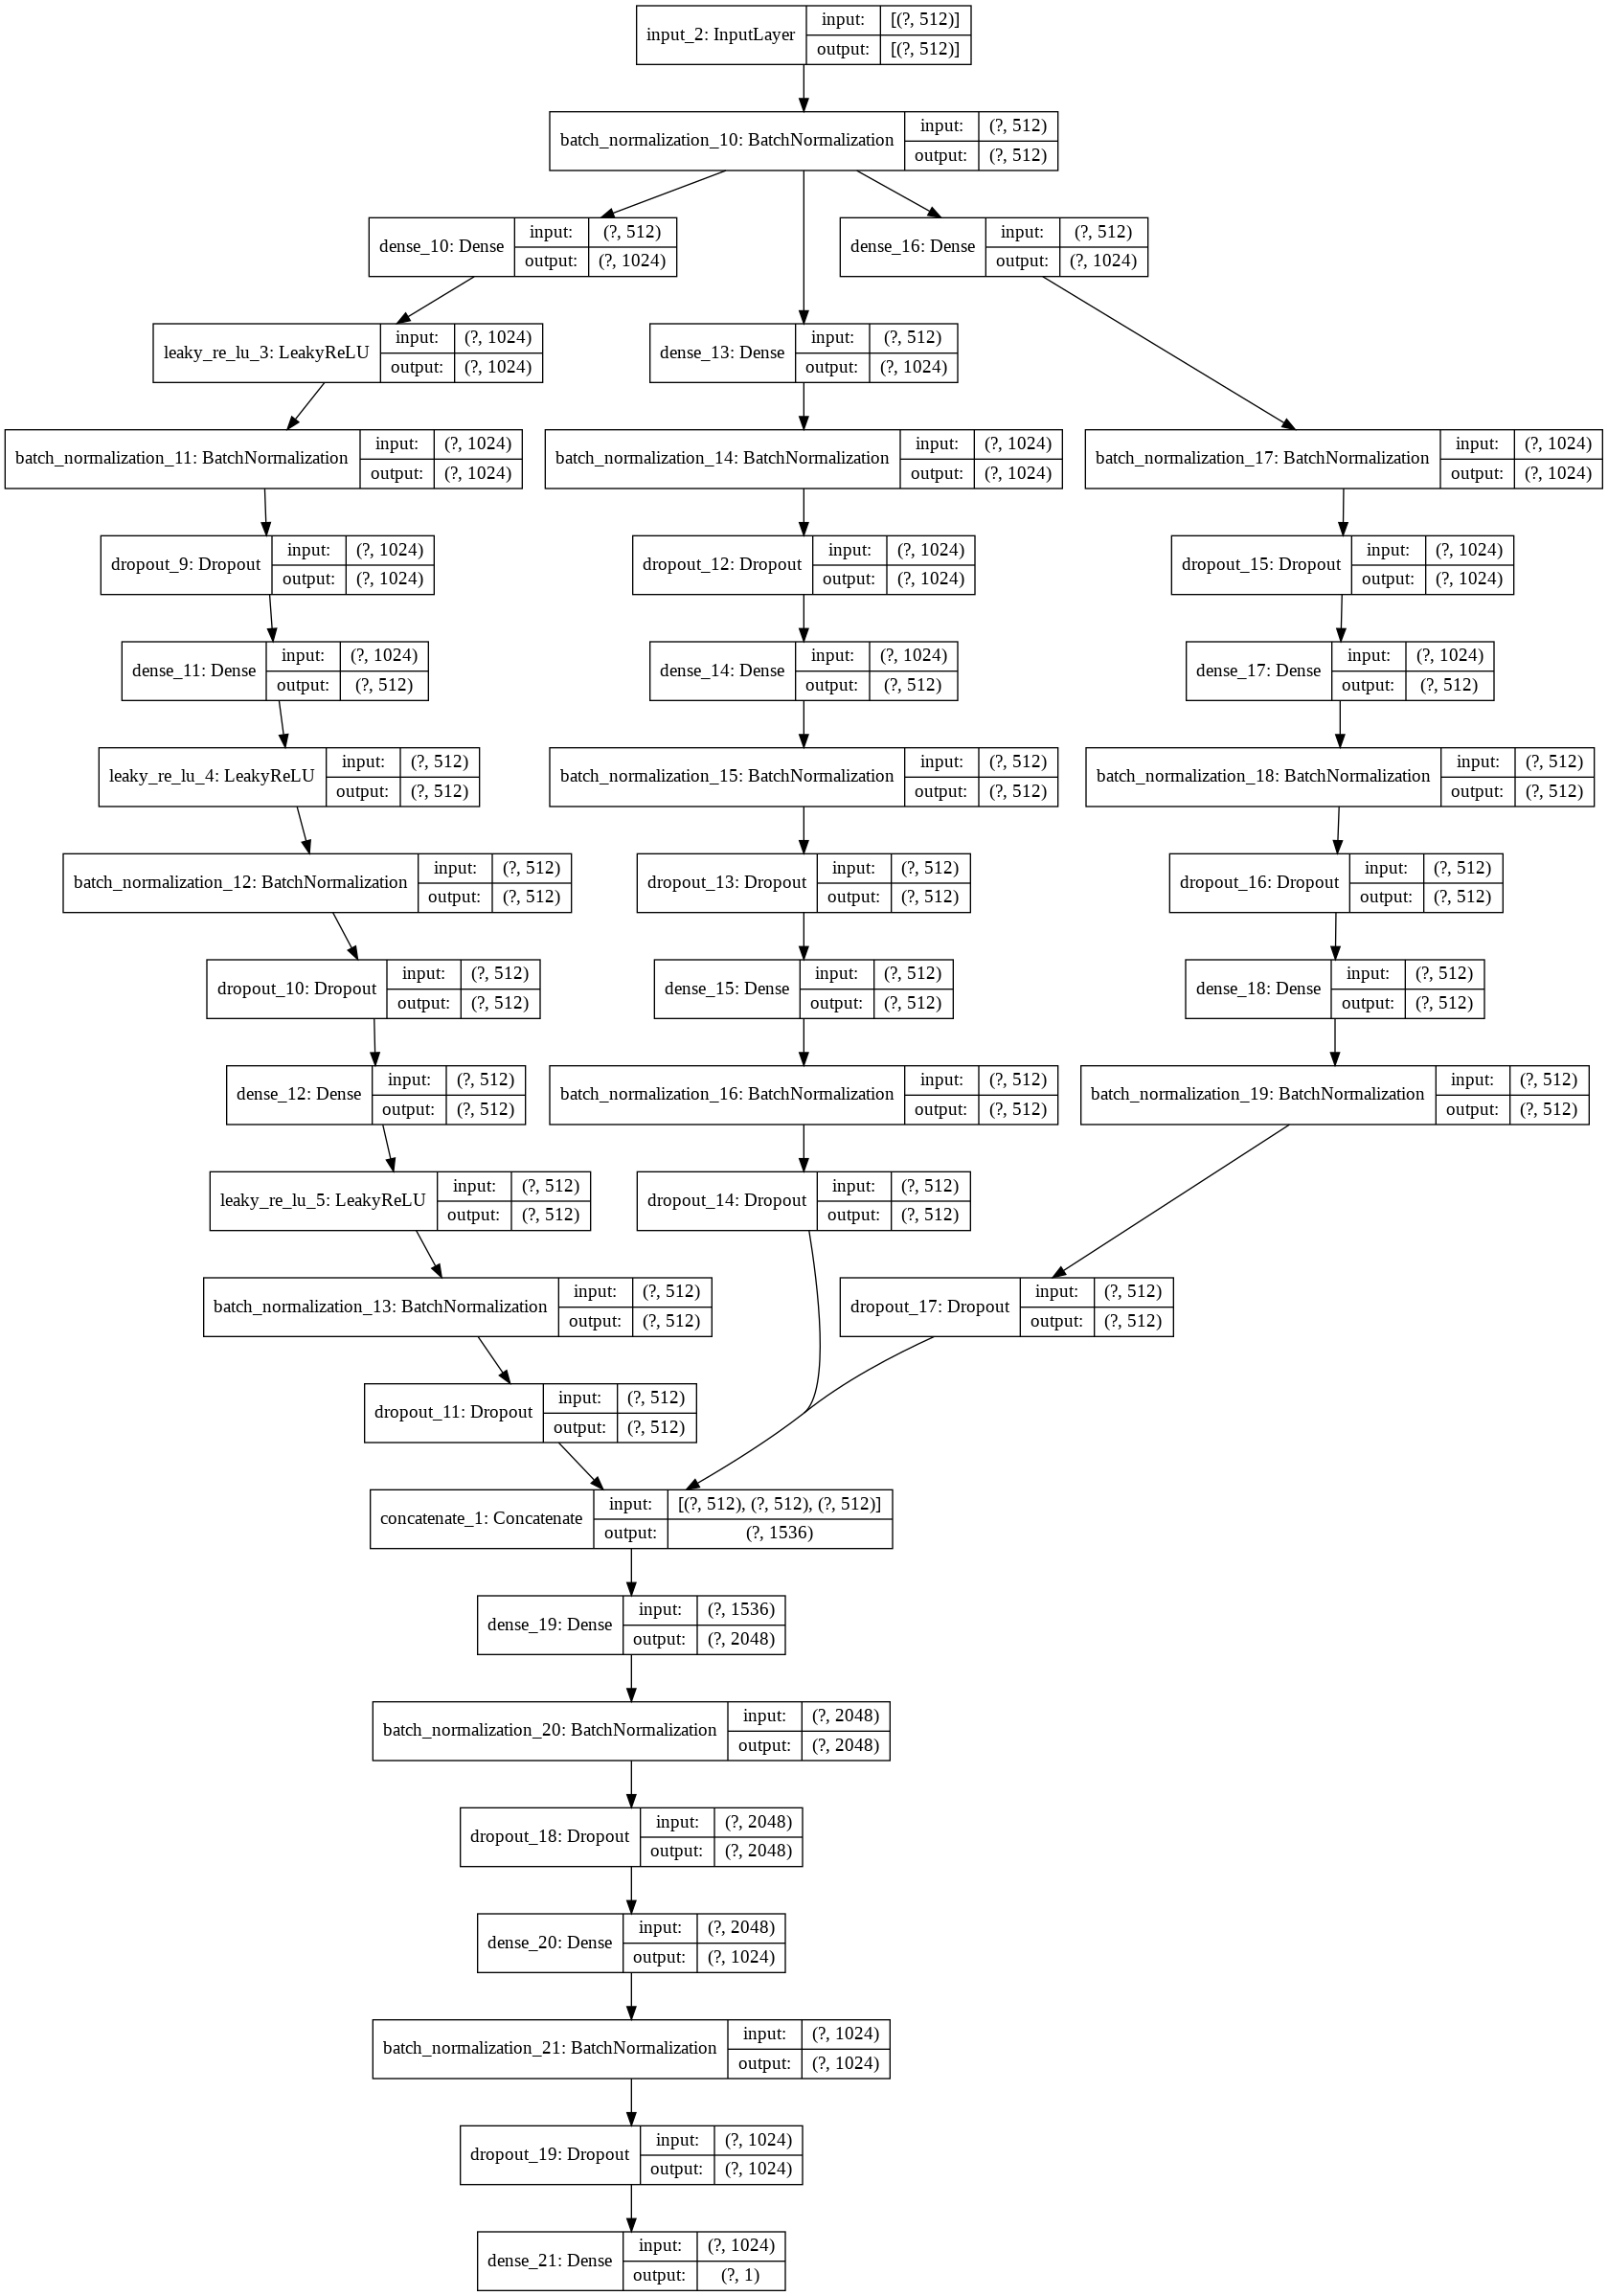

In [13]:
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/The Great Hiring Challenge/Experiment-2/TGHC-DNN_Model.png', show_shapes=True, show_layer_names=True)

Epoch 1/2
1113/1113 [==============================] - 26s 23ms/step - loss: 6.6807 - rmse: 2.2017
Epoch 2/2
1113/1113 [==============================] - 25s 23ms/step - loss: 4.4111 - rmse: 1.6021


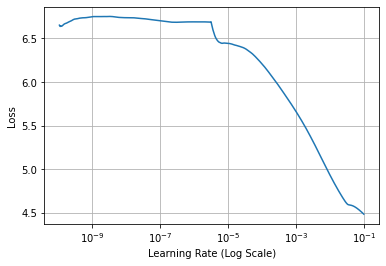

In [14]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [15]:
# Define K-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
oof_rmse_score = 0
y_pred_final = 0
counter = 0

for train, val in kfold.split(Xtrain.values, Ytrain.values):
    counter += 1

    train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
    val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
    
    # Create the model
    model = tghc_model(Xtrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='mse', metrics=[RootMeanSquaredError(name='rmse')],
                  optimizer=Lookahead(AdamW(lr=1e-1, 
                                            weight_decay=1e-5, 
                                            clipvalue=700), 
                                      sync_period=10))

    # Early stopping policy
    early = EarlyStopping(monitor="val_rmse", mode="min", 
                          restore_best_weights=True, 
                          patience=10, verbose=1)

    # Reduce LR on plateau policy
    reduce_lr = ReduceLROnPlateau(monitor="val_rmse", factor=0.1, 
                                  min_lr=1e-5, patience=5, 
                                  verbose=1, mode='min')

    # Fit the model
    history = model.fit(x=train_x, y=train_y, 
                        batch_size=mini_batch_size, epochs=125, verbose=1,
                        callbacks=[reduce_lr, early], workers=5,
                        validation_data=(val_x, val_y))
    
    # Make predictions
    y_pred = model.predict(val_x)
    y_pred_final += model.predict(Xpredict)
    score = np.sqrt(mean_squared_error(val_y, y_pred))
    oof_rmse_score += score
    print("Fold-{} | RMSE Score: {}".format(counter, score))

y_pred_final /= float(counter)
oof_rmse_score /= float(counter)
print("Aggregate RMSE Score: {}".format(oof_rmse_score))

Epoch 1/125
1002/1002 [==============================] - 23s 23ms/step - loss: 35.8524 - rmse: 2.9475 - val_loss: 5.4614 - val_rmse: 0.7932
Epoch 2/125
1002/1002 [==============================] - 22s 22ms/step - loss: 2.9806 - rmse: 0.7409 - val_loss: 2.6465 - val_rmse: 1.0102
Epoch 3/125
1002/1002 [==============================] - 22s 22ms/step - loss: 0.9607 - rmse: 0.5953 - val_loss: 1.0377 - val_rmse: 0.7946
Epoch 4/125
1002/1002 [==============================] - 22s 22ms/step - loss: 0.7453 - rmse: 0.5813 - val_loss: 1.2559 - val_rmse: 0.8795
Epoch 5/125
1002/1002 [==============================] - 23s 23ms/step - loss: 0.7864 - rmse: 0.5874 - val_loss: 0.7713 - val_rmse: 0.6276
Epoch 6/125
1002/1002 [==============================] - 23s 23ms/step - loss: 0.8812 - rmse: 0.6000 - val_loss: 0.9688 - val_rmse: 0.6960
Epoch 7/125
1002/1002 [==============================] - 23s 23ms/step - loss: 1.0022 - rmse: 0.6133 - val_loss: 1.2005 - val_rmse: 0.7978
Epoch 8/125
1002/1002 [===

KeyboardInterrupt: ignored

In [ ]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Create submission file

In [ ]:
tmp = np.array([y_pred_final]).T
y_pred_final = pt.inverse_transform(tmp)
submit_df = pd.DataFrame(y_pred_final, columns=['UnitPrice'])
print(submit_df.shape)
submit_df.head()

(122049, 1)


,UnitPrice
0,2.650892
1,2.331591
2,4.793659
3,2.642776
4,13.796221


In [ ]:
submit_df.to_csv('/content/drive/My Drive/Colab Notebooks/The Great Hiring Challenge/Experiment-2/Predictions/predictions_v11_DNN.csv', index=False)